# Wireless Drone Data Analysis

## Imports & Useful Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def merge_data(file1, file2):
    df1 = pd.read_csv(file1, comment='#')
    df2 = pd.read_csv(file2, comment='#')

    freq = pd.concat([df1['Frequency (Hz)'], df2['Frequency (Hz)']])
    mag = pd.concat([df1['Channel 4 Magnitude (dB)'], df2['Channel 4 Magnitude (dB)']])

    sort_idx = freq.argsort()
    freq = freq.iloc[sort_idx]
    mag = mag.iloc[sort_idx]

    return freq, mag

In [42]:
def get_res_freq(freq, mag):
    idx = np.argmax(mag)
    return freq.iloc[idx]

In [43]:
def calc_ind(res, C=220*1e-9):
    return 1/(C*(2*np.pi*res)**2)

In [44]:
def get_Q_factor(freq, mag):
    freq = freq.to_numpy()
    mag = mag.to_numpy()
    
    peak_idx = np.argmax(mag)
    f_peak = freq[peak_idx]
    thresh = mag[peak_idx] - 3

    left_idxs = np.where(mag[:peak_idx] <= thresh)[0]
    f_left = freq[left_idxs[-1]]

    right_idxs = np.where(mag[peak_idx:] <= thresh)[0]
    f_right = freq[peak_idx + right_idxs[0]]

    return f_peak / (f_right - f_left)

In [17]:
def print_meas_deets(filename):
    df = pd.read_csv(filename, comment='#')
    print(f'Power Supply Voltage: {df['Value'][0]}')
    print(f'TX Current:           {df['Value'][1]}')
    print(f'TX Amplitude:         {df['Value'][2]}')
    print(f'TX Frequency:         {df['Value'][3]}')
    print(f'RX Average:           {df['Value'][5]}')
    print(f'RX Frequency:         {df['Value'][6]}')

## 11-13-25 RX Coil Measurements
Measurements of the following RX coils:
- Coil 1: coil + 220 nF cap
- Coil 2: coil + 220 nF cap
    - identical to 1
- Coil 3: coil + header pins + 220 nF cap
- Coil 4: coil + 220 nF cap
    - identical to 1 and 2
- Coil 5: coil + header pins + 220 nF cap
    - identical to 3

each L has 8 windings with ~27 mm diameter, all capacitors are *not* C0G caps

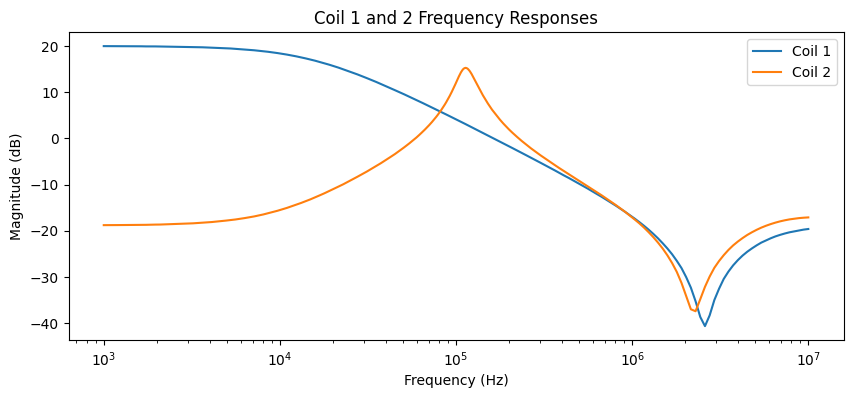

In [71]:
coil1 = pd.read_csv('11-13_RX_coils/coil1_freq.csv', comment='#')
# print(coil1.columns)
freq2, mag2 = merge_data('11-13_RX_coils/coil2_freq.csv', '11-13_RX_coils/coil2_freq_zoomed.csv')

plt.figure(figsize=(10,4))
plt.semilogx(coil1['Frequency (Hz)'], coil1['Channel 4 Magnitude (dB)'], label='Coil 1')
plt.semilogx(freq2, mag2, label='Coil 2')
plt.title('Coil 1 and 2 Frequency Responses')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.show()

**Conclusion: Coil 1 capacitor (which was not C0G) has been fried**

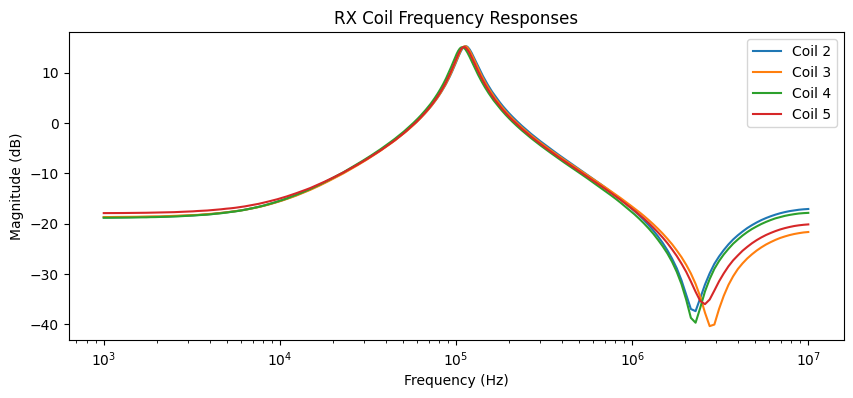

In [72]:
freq3, mag3 = merge_data('11-13_RX_coils/coil3_freq.csv', '11-13_RX_coils/coil3_freq_zoomed.csv')
freq4, mag4 = merge_data('11-13_RX_coils/coil4_freq.csv', '11-13_RX_coils/coil4_freq_zoomed.csv')
freq5, mag5 = merge_data('11-13_RX_coils/coil5_freq.csv', '11-13_RX_coils/coil5_freq_zoomed.csv')

plt.figure(figsize=(10,4))
plt.semilogx(freq2, mag2, label='Coil 2')
plt.semilogx(freq3, mag3, label='Coil 3')
plt.semilogx(freq4, mag4, label='Coil 4')
plt.semilogx(freq5, mag5, label='Coil 5')

plt.title('RX Coil Frequency Responses')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.show()

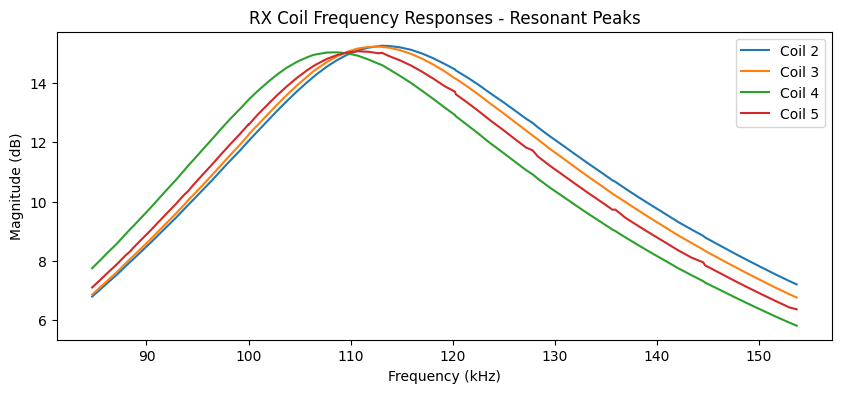

In [73]:
plt.figure(figsize=(10,4))
plt.plot(freq2[130:205]*1e-3, mag2[130:205], label='Coil 2')
plt.plot(freq3[130:205]*1e-3, mag3[130:205], label='Coil 3')
plt.plot(freq4[130:205]*1e-3, mag4[130:205], label='Coil 4')
plt.plot(freq5[130:205]*1e-3, mag5[130:205], label='Coil 5')

plt.title('RX Coil Frequency Responses - Resonant Peaks')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.show()

# print(len(freq2))

In [74]:
res2 = get_res_freq(freq2, mag2)
res3 = get_res_freq(freq3, mag3)
res4 = get_res_freq(freq4, mag4)
res5 = get_res_freq(freq5, mag5)

print(f'Coil 2 Resonant Frequency: {res2*1e-3:.2f} kHz')
print(f'Coil 3 Resonant Frequency: {res3*1e-3:.2f} kHz')
print(f'Coil 4 Resonant Frequency: {res4*1e-3:.2f} kHz')
print(f'Coil 5 Resonant Frequency: {res5*1e-3:.2f} kHz')

avg_res = np.mean([res2, res3, res4, res5])
res_std = np.std([res2, res3, res4, res5])
print(f'\nOverall Resonant Frequency: {avg_res*1e-3:.2f} kHz \u00B1 {res_std*1e-3:.2f} kHz')

Coil 2 Resonant Frequency: 113.07 kHz
Coil 3 Resonant Frequency: 112.77 kHz
Coil 4 Resonant Frequency: 108.67 kHz
Coil 5 Resonant Frequency: 110.70 kHz

Overall Resonant Frequency: 111.30 kHz ± 1.77 kHz


In [75]:
L2 = calc_ind(res2)
L3 = calc_ind(res3)
L4 = calc_ind(res4)
L5 = calc_ind(res5)

print(f'Inductance of Coil 2: {L2*1e6:.2f} \u03BCH')
print(f'Inductance of Coil 3: {L3*1e6:.2f} \u03BCH')
print(f'Inductance of Coil 4: {L4*1e6:.2f} \u03BCH')
print(f'Inductance of Coil 5: {L5*1e6:.2f} \u03BCH')

avg_L = np.mean([L2, L3, L4, L5])
L_std = np.std([L2, L3, L4, L5])
print(f'\nOverall RX Coil Inductance: {avg_L*1e6:.2f} \u03BCH \u00B1 {L_std*1e6:.2f} \u03BCH')

Inductance of Coil 2: 9.01 μH
Inductance of Coil 3: 9.05 μH
Inductance of Coil 4: 9.75 μH
Inductance of Coil 5: 9.40 μH

Overall RX Coil Inductance: 9.30 μH ± 0.30 μH


In [76]:
Q2 = get_Q_factor(freq2, mag2)
Q3 = get_Q_factor(freq3, mag3)
Q4 = get_Q_factor(freq4, mag4)
Q5 = get_Q_factor(freq5, mag5)

print(f'Coil 2 Q Factor: {Q2:.2f}')
print(f'Coil 3 Q Factor: {Q3:.2f}')
print(f'Coil 4 Q Factor: {Q4:.2f}')
print(f'Coil 5 Q Factor: {Q5:.2f}')

Coil 2 Q Factor: 3.83
Coil 3 Q Factor: 3.85
Coil 4 Q Factor: 3.85
Coil 5 Q Factor: 3.82


**Conclusion: RX coils have slightly significant differences (?) which should be accounted for**

**Conclusion: the addition header pins does not effect the frequency response**

---

Now looking RLC circuits using Coil 5 and various resistane values:

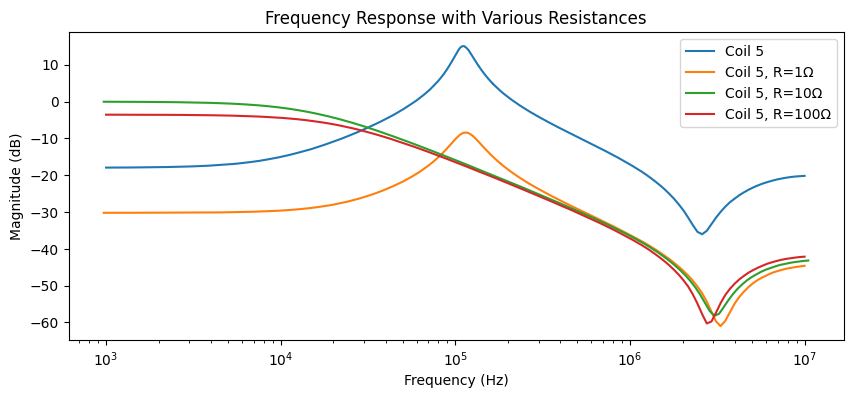

In [77]:
freq_R1, mag_R1 = merge_data('11-13_RX_coils/coil5_R1_freq.csv', '11-13_RX_coils/coil5_R1_freq_zoomed.csv')

dfR10 = pd.read_csv('11-13_RX_coils/coil5_R10_freq.csv', comment='#')
dfR100 = pd.read_csv('11-13_RX_coils/coil5_R100_freq.csv', comment='#')

plt.figure(figsize=(10,4))
plt.semilogx(freq5, mag5, label='Coil 5')
plt.semilogx(freq_R1, mag_R1, label='Coil 5, R=1\u03A9')
plt.semilogx(dfR10['Frequency (Hz)'], dfR10['Channel 4 Magnitude (dB)'], label='Coil 5, R=10\u03A9')
plt.semilogx(dfR100['Frequency (Hz)'], dfR100['Channel 4 Magnitude (dB)'], label='Coil 5, R=100\u03A9')
plt.title('Frequency Response with Various Resistances')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.show()

**Conclusion: Resistances >=10 damp out the resonant peak and should not be used for data collection**

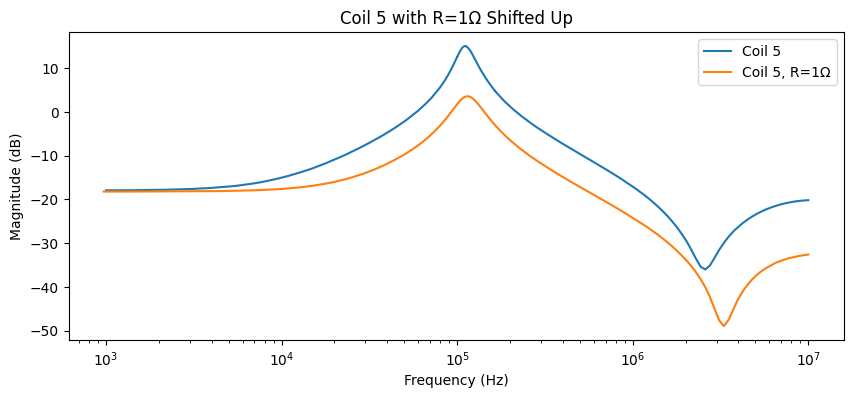

In [78]:
# print(mag5.iloc[0])
# print(mag_R1.iloc[0])

plt.figure(figsize=(10,4))
plt.semilogx(freq5, mag5, label='Coil 5')
plt.semilogx(freq_R1, mag_R1+12, label='Coil 5, R=1\u03A9')
plt.title('Coil 5 with R=1\u03A9 Shifted Up')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.show()

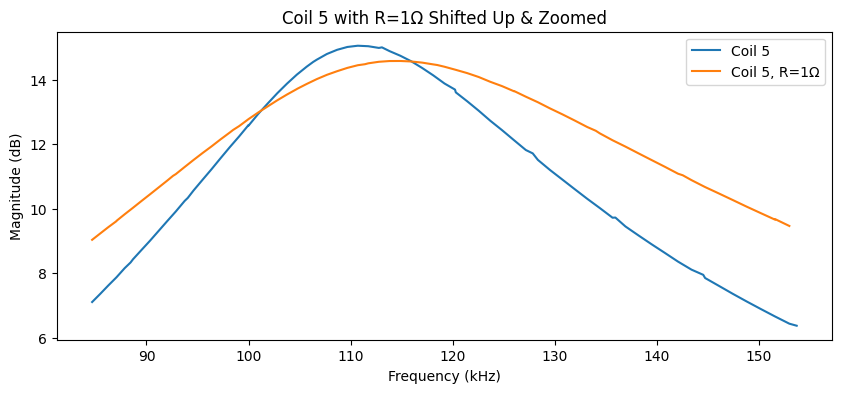

In [79]:
plt.figure(figsize=(10,4))
plt.plot(freq5[130:205]*1e-3, mag5[130:205], label='Coil 5')
plt.plot(freq_R1[130:205]*1e-3, mag_R1[130:205]+23, label='Coil 5, R=1\u03A9')
plt.title('Coil 5 with R=1\u03A9 Shifted Up & Zoomed')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.show()

In [80]:
res_R1 = get_res_freq(freq_R1, mag_R1)

print(f'Coil 5 Resonant Frequency: {res5*1e-3:.2f} kHz')
print(f'Coil 5 Resonant Frequency with R=1\u03A9: {res_R1*1e-3:.2f} kHz')

Coil 5 Resonant Frequency: 110.70 kHz
Coil 5 Resonant Frequency with R=1Ω: 114.87 kHz


In [81]:
QR1 = get_Q_factor(freq_R1, mag_R1)

print(f'Coil 5 Q Factor: {Q5:.2f}')
print(f'Coil 5 Q Factor with R=1\u03A9: {QR1:.2f}')

Coil 5 Q Factor: 3.82
Coil 5 Q Factor with R=1Ω: 2.56


**Conclusion: Presence of resistive load significantly impacts the resonant frequency**

In [82]:
well_df = pd.read_csv('11-13_RX_coils/well_merged.csv')

print('RX Coil Amplitude for various coils/resistors:')

for _, row in well_df.iterrows():
    file = row['File Name']
    file = file[:-4].replace('_', ' ')
    
    RX_amp = row['RX Amplitude (V)']

    print(f'{file:<12}  {RX_amp} V')

RX Coil Amplitude for various coils/resistors:
coil2         4.9151 V
coil3         4.5314 V
coil4         3.946 V
coil5 R1      3.3823 V
coil5 R10     0.8436 V
coil5 R100    0.09658 V
coil5         4.107 V


Note: shouldn't read too much into the actual magnitude of the readings because positions may have changed between tests, instead look at order of magnitude. 

**Conclusion: Presence of load significantly decreases amplitude of induced voltage in RX coil**

## 11-17-25 RX Coil Measurements

Measurements of the following RX coils, all with both standard cap and C0G cap:
- Coil 5 
- Coil 5 + 1 Ohm resistor
- Coil 5 + full wave rectifier + 1 Ohm resistor

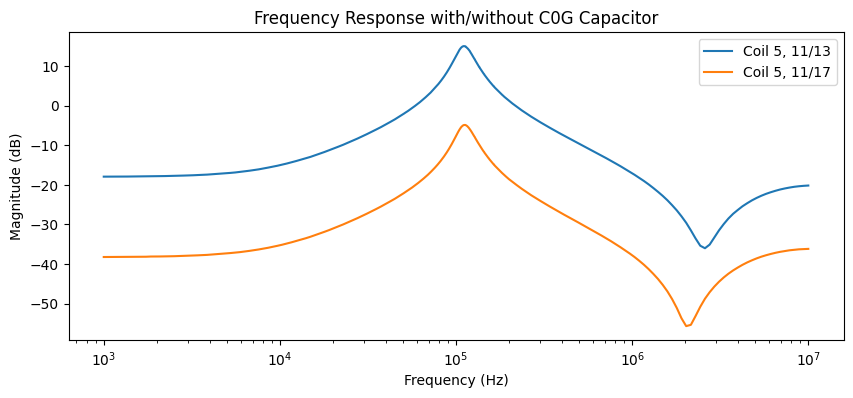

Resonant Frequency 11/13: 110.70 kHz
Resonant Frequency 11/17: 111.73 kHz

Q Factor 11/13: 3.82
Q Factor 11/17: 3.88


In [7]:
# differences between coil 5 measurement on 11-13 and 11-17

freq5_13, mag5_13 = merge_data('11-13_RX_coils/coil5_freq.csv', '11-13_RX_coils/coil5_freq_zoomed.csv')
freq5_17, mag5_17 = merge_data('11-17_RX_coils/coil5_freq.csv', '11-17_RX_coils/coil5_freq_zoomed.csv')

plt.figure(figsize=(10,4))
plt.semilogx(freq5_13, mag5_13, label='Coil 5, 11/13')
plt.semilogx(freq5_17, mag5_17, label='Coil 5, 11/17')
plt.title('Frequency Response with/without C0G Capacitor')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.show()

res5_13 = get_res_freq(freq5_13, mag5_13)
res5_17 = get_res_freq(freq5_17, mag5_17)
print(f'Resonant Frequency 11/13: {res5_13*1e-3:.2f} kHz')
print(f'Resonant Frequency 11/17: {res5_17*1e-3:.2f} kHz')
print('')

Q5_13 = get_Q_factor(freq5_13, mag5_13)
Q5_17 = get_Q_factor(freq5_17, mag5_17)
print(f'Q Factor 11/13: {Q5_13:.2f}')
print(f'Q Factor 11/17: {Q5_17:.2f}')

Note: difference between measurements on different days, but only in terms of relative magnitude, else should be same

Better to compare C0G and not C0G caps with measurments from same day:

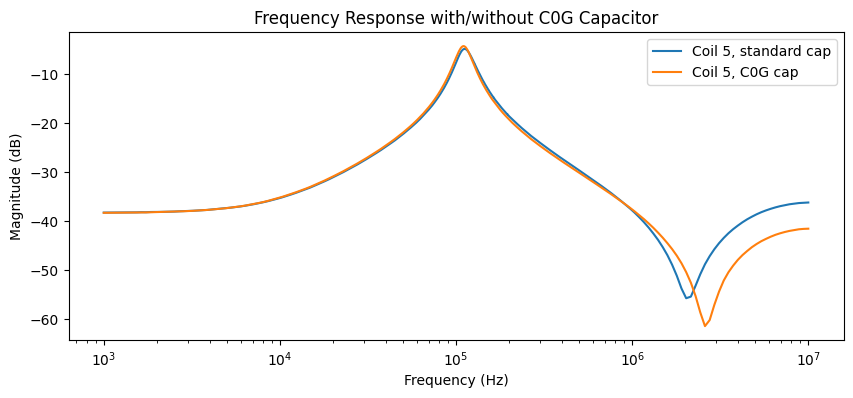

In [8]:
freq5, mag5 = merge_data('11-17_RX_coils/coil5_freq.csv', '11-17_RX_coils/coil5_freq_zoomed.csv')
freq5_c0g, mag5_c0g = merge_data('11-17_RX_coils/coil5_C0G_freq.csv', '11-17_RX_coils/coil5_C0G_freq_zoomed.csv')

plt.figure(figsize=(10,4))
plt.semilogx(freq5, mag5, label='Coil 5, standard cap')
plt.semilogx(freq5_c0g, mag5_c0g, label='Coil 5, C0G cap')
plt.title('Frequency Response with/without C0G Capacitor')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.show()

In [10]:
res5 = get_res_freq(freq5, mag5)
res5_c0g = get_res_freq(freq5_c0g, mag5_c0g)

print('Resonant Frequencies')
print(f'Standard Cap: {res5_17*1e-3:.2f} kHz')
print(f'C0G Cap:      {res5_c0g*1e-3:.2f} kHz')

Resonant Frequencies
Standard Cap: 111.73 kHz
C0G Cap:      110.70 kHz


In [11]:
Q5 = get_Q_factor(freq5, mag5)
Q5_c0g = get_Q_factor(freq5_c0g, mag5_c0g)

print('Q Factors')
print(f'Standard Cap: {Q5:.2f}')
print(f'C0G Cap     : {Q5_c0g:.2f}')

Q Factors
Standard Cap: 3.88
C0G Cap     : 4.15


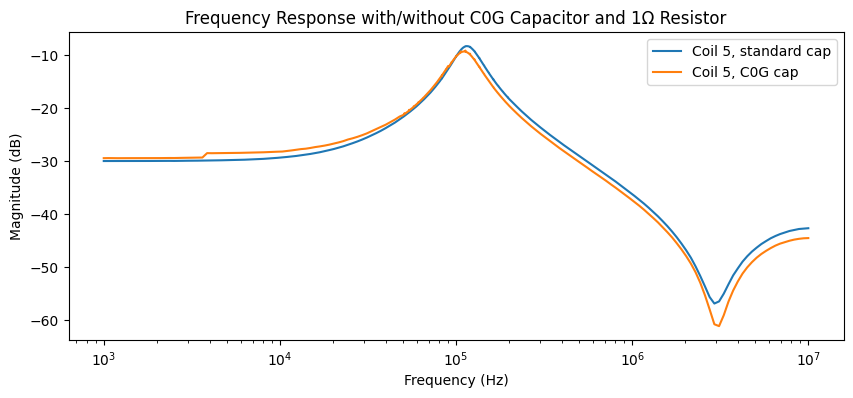

In [14]:
freq5R1, mag5R1 = merge_data('11-17_RX_coils/coil5_R1_freq.csv', '11-17_RX_coils/coil5_R1_freq_zoomed.csv')
freq5R1_c0g, mag5R1_c0g = merge_data('11-17_RX_coils/coil5_C0G_R1_freq.csv', '11-17_RX_coils/coil5_C0G_R1_freq_zoomed.csv')

plt.figure(figsize=(10,4))
plt.semilogx(freq5R1, mag5R1, label='Coil 5, standard cap')
plt.semilogx(freq5R1_c0g, mag5R1_c0g, label='Coil 5, C0G cap')
plt.title('Frequency Response with/without C0G Capacitor and 1\u03A9 Resistor')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.show()

In [13]:
res5R1 = get_res_freq(freq5R1, mag5R1)
res5R1_c0g = get_res_freq(freq5R1_c0g, mag5R1_c0g)

Q5R1 = get_Q_factor(freq5R1, mag5R1)
Q5R1_c0g = get_Q_factor(freq5R1_c0g, mag5R1_c0g)

print('Resonant Frequencies')
print(f'Standard Cap: {res5R1*1e-3:.2f} kHz')
print(f'C0G Cap:      {res5R1_c0g*1e-3:.2f} kHz')

print('\nQ Factors')
print(f'Standard Cap: {Q5R1:.2f}')
print(f'C0G Cap:      {Q5R1_c0g:.2f}')

Resonant Frequencies
Standard Cap: 115.94 kHz
C0G Cap:      113.07 kHz

Q Factors
Standard Cap: 2.56
C0G Cap:      2.54


**Conclusion: no obivous differences in frequency sweeps between standard cap and C0G cap**

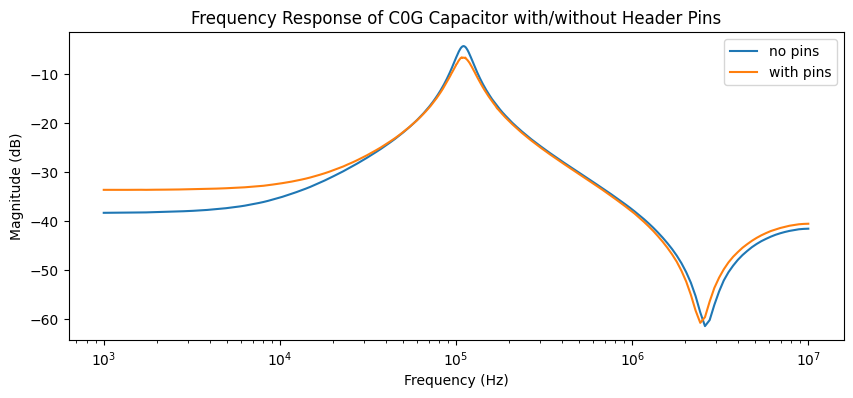

Resonant Frequencies:
No pins:   110.70 kHz
With pins: 107.67 kHz

Q Factors:
No pins:   4.15
With pins: 3.24


In [105]:
# tested C0G cap with male-male header pins because its own pins are short
freq_c0g_pins, mag_c0g_pins = merge_data('11-17_RX_coils/coil5_C0G_headers_freq.csv', 
                                         '11-17_RX_coils/coil5_C0G_headers_freq_zoomed.csv')

plt.figure(figsize=(10,4))
plt.semilogx(freq5_c0g, mag5_c0g, label='no pins')
plt.semilogx(freq_c0g_pins, mag_c0g_pins, label='with pins')
plt.title('Frequency Response of C0G Capacitor with/without Header Pins')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.show()

res_pins = get_res_freq(freq_c0g_pins, mag_c0g_pins)
Q_pins = get_Q_factor(freq_c0g_pins, mag_c0g_pins)

print('Resonant Frequencies:')
print(f'No pins:   {res5_c0g*1e-3:.2f} kHz')
print(f'With pins: {res_pins*1e-3:.2f} kHz')

print('\nQ Factors:')
print(f'No pins:   {Q5_c0g:.2f}')
print(f'With pins: {Q_pins:.2f}')

**Conclusion: using male-to-male header pins significantly alters the frequency response**

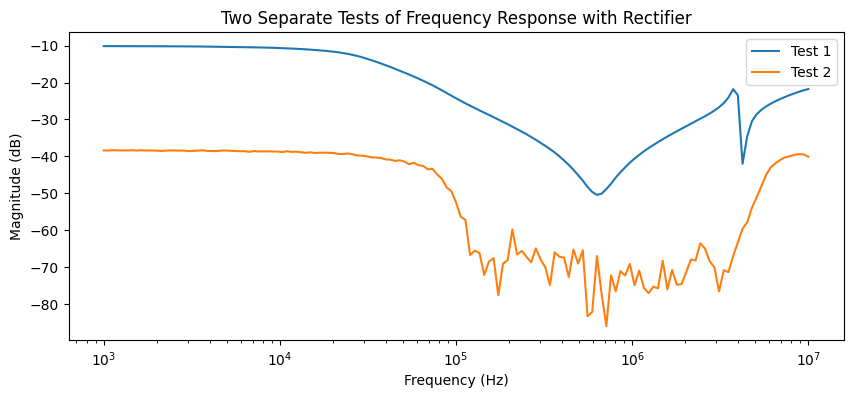

In [108]:
df_c0g1 = pd.read_csv('11-17_RX_coils/coil5_C0G_R1_rect_freq.csv', comment='#')
df_c0g2 = pd.read_csv('11-17_RX_coils/coil5_C0G_R1_rect_freq2.csv', comment='#')

plt.figure(figsize=(10,4))
plt.semilogx(df_c0g1['Frequency (Hz)'], df_c0g1['Channel 4 Magnitude (dB)'], label='Test 1')
plt.semilogx(df_c0g2['Frequency (Hz)'], df_c0g2['Channel 4 Magnitude (dB)'], label='Test 2')
plt.title('Two Separate Tests of Frequency Response with Rectifier')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.show()

Results of test 1 were unable to be recreated; it is a much nicer curve but it might have been a fluke. Or perhaps the full-wave rectifier was used at frequencies outside its intended usage and so it broke and now gives a weird curve.

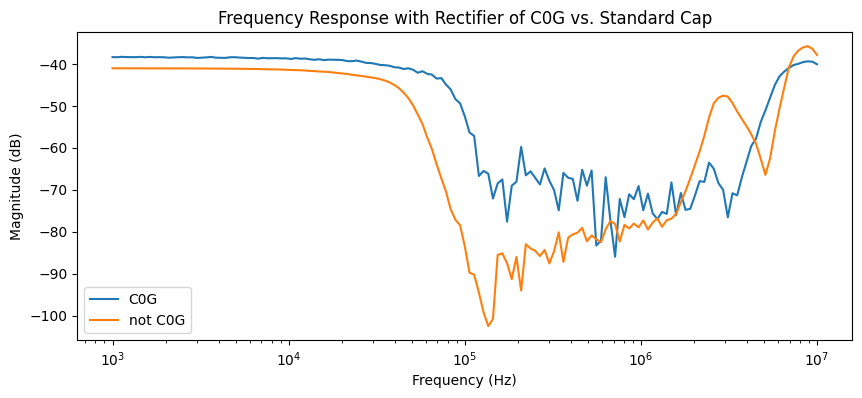

In [116]:
df_1V = pd.read_csv('11-17_RX_coils/coil5_R1_rect_freq_1V.csv', comment='#')

plt.figure(figsize=(10,4))
plt.semilogx(df_c0g2['Frequency (Hz)'], df_c0g2['Channel 4 Magnitude (dB)'], label='C0G')
plt.semilogx(df_1V['Frequency (Hz)'], df_1V['Channel 4 Magnitude (dB)'], label='not C0G')
plt.title('Frequency Response with Rectifier of C0G vs. Standard Cap')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.show()

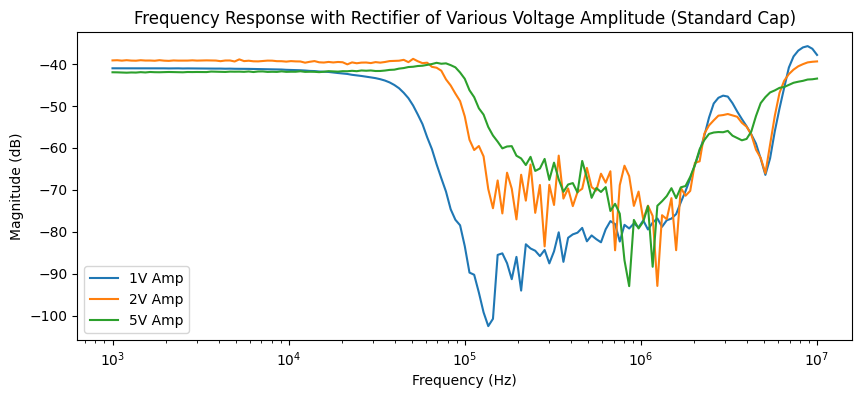

In [118]:
df_2V = pd.read_csv('11-17_RX_coils/coil5_R1_rect_freq_2V.csv', comment='#')
df_5V = pd.read_csv('11-17_RX_coils/coil5_R1_rect_freq_5V.csv', comment='#')

plt.figure(figsize=(10,4))
plt.semilogx(df_1V['Frequency (Hz)'], df_1V['Channel 4 Magnitude (dB)'], label='1V Amp')
plt.semilogx(df_2V['Frequency (Hz)'], df_2V['Channel 4 Magnitude (dB)'], label='2V Amp')
plt.semilogx(df_5V['Frequency (Hz)'], df_5V['Channel 4 Magnitude (dB)'], label='5V Amp')
plt.title('Frequency Response with Rectifier of Various Voltage Amplitude (Standard Cap)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.show()

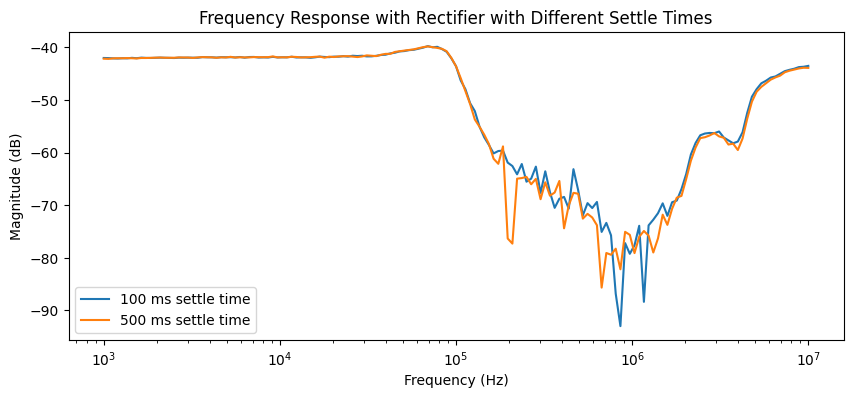

In [120]:
df_5Vlong = pd.read_csv('11-17_RX_coils/coil5_R1_rect_freq_5V_longer_settle.csv', comment='#')

plt.figure(figsize=(10,4))
plt.semilogx(df_5V['Frequency (Hz)'], df_5V['Channel 4 Magnitude (dB)'], label='100 ms settle time')
plt.semilogx(df_5Vlong['Frequency (Hz)'], df_5Vlong['Channel 4 Magnitude (dB)'], label='500 ms settle time')
plt.title('Frequency Response with Rectifier with Different Settle Times')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.show()

**Conclusion: full-wave rectifier significantly impacts frequency response**

## 11-18-25 RX Coil Measurement with Motor
Measurement and scope trace of an RX coil with a C0G cap, full-wave rectifer and motor in the TX well

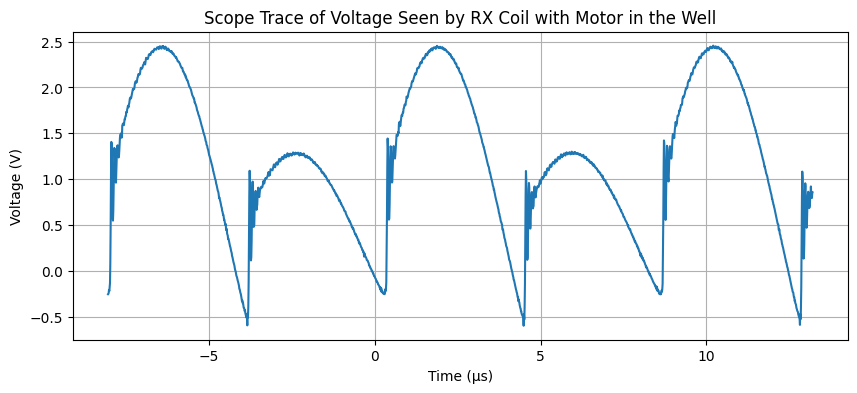

Measurement Details:
Power Supply Voltage:  10.580 V
TX Current:            13.507 A
TX Amplitude:          279.76 V
RX Average:            1.149 V
RX/TX Frequency:       120.05 kHz


In [55]:
motor = pd.read_csv('11-18_RX_motor/scope.csv', comment='#')
meas = pd.read_csv('11-18_RX_motor/meas.csv', comment='#')

avg = np.mean(motor['Channel 4 (V)']*10)
rms = np.sqrt(np.mean((motor['Channel 4 (V)']*10)**2))

plt.figure(figsize=(10,4))
plt.plot(motor['Time (s)'][14875:17000]*1e6, motor['Channel 4 (V)'][14875:17000]*10, label='Motor Voltage')
# plt.axhline(y=avg, label=f'Average={avg:.2f} V', color='r', linestyle='--')
plt.title('Scope Trace of Voltage Seen by RX Coil with Motor in the Well')
plt.xlabel('Time (\u03BCs)')
plt.ylabel('Voltage (V)')
plt.grid()
# plt.legend()
plt.show()

# print(f'Average Voltage: {avg:.2f} V')
# print(f'RMS Voltage:     {rms:.2f} V')
# print('')

# print(meas)
print('Measurement Details:')
print(f'Power Supply Voltage: {meas['Value'][0]}')
print(f'TX Current:           {meas['Value'][1]}')
print(f'TX Amplitude:         {meas['Value'][2]}')
print(f'RX Average:            {avg:.3f} V')
print(f'RX/TX Frequency:      {meas['Value'][3]}')

## 11-19-25 Probe and RX Motor Coil Measurements in Well
Measurements and scope traces of
- the probe in the well by itself, not connected to anything
- the rectified voltage across the motor with various smoothing capacitors

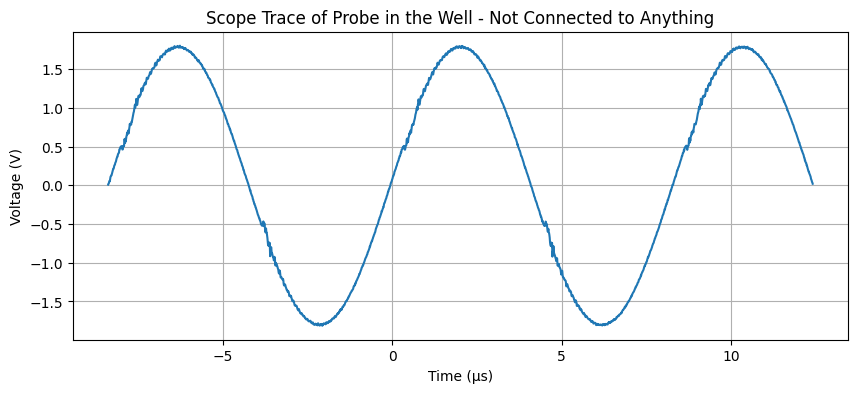

Measurement Details:
Power Supply Voltage:  10.952 V
TX Current:            17.453 A
TX Amplitude:          304.65 V
RX Ampltidue:          1.7884 V
RX Average:            1.5517 mV
RX/TX Frequency:       120.05 kHz

Position 2 Measurement Details:
Power Supply Voltage:  11.334 V
TX Current:            15.848 A
TX Amplitude:          317.89 V
Frequency:             120.05 kHz
RX Ampltidue:          1.6300 V
RX Average:            10.191 mV


In [59]:
probe1 = pd.read_csv('11-19_RX_motor/probe.csv', comment='#')
probe2 = pd.read_csv('11-19_RX_motor/probe2.csv', comment='#')

plt.figure(figsize=(10,4))
plt.plot(probe1['Time (s)'][14840:16920]*1e6, probe1['Channel 4 (V)'][14840:16920]*10, label='pos1')
# plt.plot(probe2['Time (s)'][14840:16920]*1e6, probe2['Channel 4 (V)'][14840:16920]*10, label='pos2')
plt.title('Scope Trace of Probe in the Well - Not Connected to Anything')
plt.xlabel('Time (\u03BCs)')
plt.ylabel('Voltage (V)')
plt.grid()
# plt.legend()
plt.show()

# p1_avg = np.mean(probe1['Channel 4 (V)']*10)
# p2_avg = np.mean(probe2['Channel 4 (V)']*10)
# print(f'Probe 1 Average Voltage: {p1_avg*1e3:.2f} mV')
# print(f'Probe 2 Average Voltage: {p2_avg*1e3:.2f} mV')

p1_meas = pd.read_csv('11-19_RX_motor/probe_meas.csv', comment='#')
p2_meas = pd.read_csv('11-19_RX_motor/probe2_meas.csv', comment='#')

# print(p1_meas)
# print(p2_meas)

# print('Position 1 Measurement Details:')
print('Measurement Details:')
print(f'Power Supply Voltage: {p1_meas['Value'][0]}')
print(f'TX Current:           {p1_meas['Value'][1]}')
print(f'TX Amplitude:         {p1_meas['Value'][2]}')
print(f'RX Ampltidue:         {p1_meas['Value'][4]}')
print(f'RX Average:           {p1_meas['Value'][6]}')
print(f'RX/TX Frequency:      {p1_meas['Value'][3]}')


print('\nPosition 2 Measurement Details:')
print(f'Power Supply Voltage: {p2_meas['Value'][0]}')
print(f'TX Current:           {p2_meas['Value'][1]}')
print(f'TX Amplitude:         {p2_meas['Value'][2]}')
print(f'Frequency:            {p2_meas['Value'][3]}')
print(f'RX Ampltidue:         {p2_meas['Value'][4]}')
print(f'RX Average:           {p2_meas['Value'][5]}')

**Conclusion: probe couples into the magnetic field, but average is small enough to be neglected from average of other readings**

In [ ]:
motor1 = pd.read_csv('11-19_RX_motor/motor.csv', comment='#')
motor1_meas = pd.read_csv('11-19_RX_motor/motor_meas.csv', comment='#')

avg = np.mean(motor1['Channel 4 (V)']*10)

plt.figure(figsize=(10,4))
plt.plot(motor['Time (s)'][14875:17000]*1e6, motor['Channel 4 (V)'][14875:17000]*10, label='Motor Voltage')
plt.axhline(y=avg, label=f'Average={avg:.2f} V', color='r', linestyle='--')
plt.title('Scope Trace of Voltage Seen by RX Coil with Motor in the Well')
plt.xlabel('Time (\u03BCs)')
plt.ylabel('Voltage (V)')
plt.grid()
plt.legend()
plt.show()

print('Measurement Details:')
print(f'Power Supply Voltage: {motor1

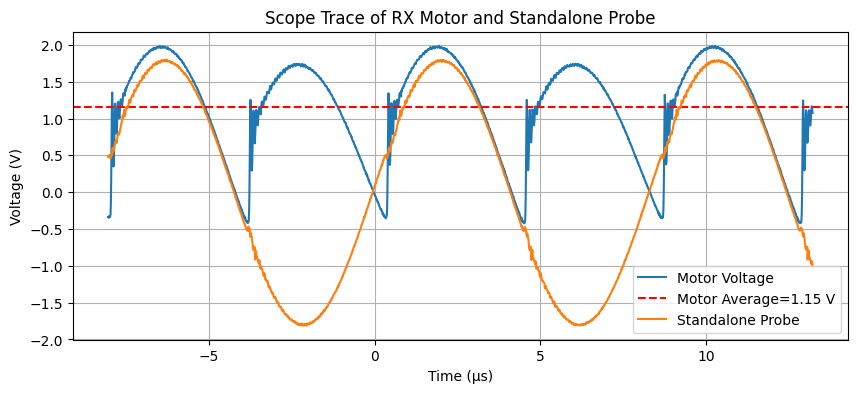

Measurement Details:
Power Supply Voltage:  10.850 V
TX Current:            17.051 A
TX Amplitude:          308.10 V
Frequency:             120.05 kHz
RX Average:            1.1541 V


In [49]:
motor1 = pd.read_csv('11-19_RX_motor/motor.csv', comment='#')
motor1_meas = pd.read_csv('11-19_RX_motor/motor_meas.csv', comment='#')

avg1 = float(motor1_meas['Value'][6].strip().split(' ')[0])

plt.figure(figsize=(10,4))
plt.plot(motor1['Time (s)'][14875:17000]*1e6, motor1['Channel 4 (V)'][14875:17000]*10, label='Motor Voltage')
plt.axhline(y=avg1, label=f'Motor Average={avg1:.2f} V', color='r', linestyle='--')
plt.plot(probe1['Time (s)'][14875:17000]*1e6, probe1['Channel 4 (V)'][14875:17000]*10, label='Standalone Probe')
plt.title('Scope Trace of RX Motor and Standalone Probe')
plt.xlabel('Time (\u03BCs)')
plt.ylabel('Voltage (V)')
plt.grid()
plt.legend()
plt.show()

print('Measurement Details:')
print(f'Power Supply Voltage: {motor1_meas['Value'][0]}')
print(f'TX Current:           {motor1_meas['Value'][1]}')
print(f'TX Amplitude:         {motor1_meas['Value'][2]}')
print(f'Frequency:            {motor1_meas['Value'][3]}')
print(f'RX Average:           {motor1_meas['Value'][6]}')

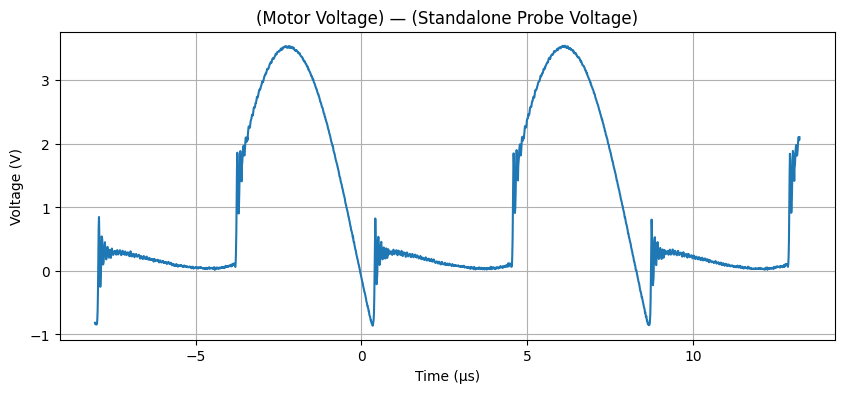

In [23]:
# fix attempt 1 - subtract probe1 measurement

motor1_fix = motor1['Channel 4 (V)']*10 - probe1['Channel 4 (V)']*10

plt.figure(figsize=(10,4))
plt.plot(motor1['Time (s)'][14875:17000]*1e6, motor1_fix[14875:17000], label='Motor Voltage')
plt.title('(Motor Voltage) \u2014 (Standalone Probe Voltage)')
plt.xlabel('Time (\u03BCs)')
plt.ylabel('Voltage (V)')
plt.grid()
plt.show()

This is not the right fix &mdash; voltage does negative when rectifed wave should never be; perhaps the magnitude of the wave coupled into the probe changes when probing an actual circuit

Assuming peaks of the rectified wave are equal and coupling from the probe is a perfect sine wave of the same frequency, we can subtract a sine wave of that frequency with amplitude such that the rectified wave has a consistent peak voltage. 

1.743425707962528
1.989146764031458


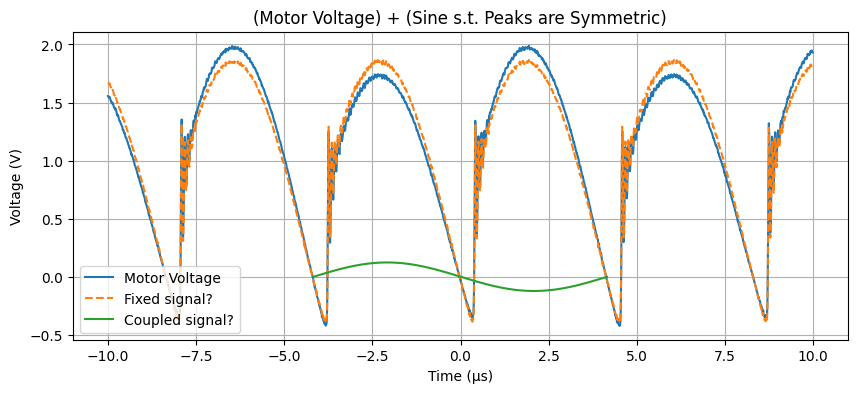

1.1102260144995941


In [53]:
# fix attempt 2 - subtract artificial sine wave (very rough work)

# print(type(motor1['Time (s)']))
time = motor1['Time (s)'].to_numpy()
voltage = motor1['Channel 4 (V)'].to_numpy()*10
freq = 120*1e3
z_idx = np.argmin(np.abs(time))
period = 1/freq
start = np.argmin(np.abs(time + period/2))
stop = np.argmin(np.abs(time - period/2))

cropped_t = time[start:stop]
cropped_V = voltage[start:stop]
peak1 = max(cropped_V[:len(cropped_t)//2])
peak2 = max(cropped_V[len(cropped_t)//2:])
print(peak1)
print(peak2)

A = (peak1 - peak2)/2
art_sin = A*np.sin(2*np.pi*freq*cropped_t)

plt.figure(figsize=(10,4))
plt.plot(motor1['Time (s)'][z_idx-1000:z_idx+1000]*1e6, motor1['Channel 4 (V)'][z_idx-1000:z_idx+1000]*10, label='Motor Voltage')
# plt.plot(time[start:stop]*1e6, voltage[start:stop], label='og')
# plt.plot(cropped_t*1e6, cropped_V + art_sin, label='fixed?')
# plt.axhline(y=peak1)
# plt.axhline(y=peak2)
# plt.axhline(y=(peak1+peak2)/2, color='r')
plt.plot(time[z_idx-1000:z_idx+1000]*1e6, voltage[z_idx-1000:z_idx+1000] + A*np.sin(2*np.pi*freq*time[z_idx-1000:z_idx+1000]), 
        '--', label='Fixed signal?')
plt.plot(cropped_t*1e6, art_sin, label='Coupled signal?')
plt.xlabel('Time (\u03BCs)')
plt.ylabel('Voltage (V)')
plt.title('(Motor Voltage) + (Sine s.t. Peaks are Symmetric)')
plt.grid()
plt.legend()
plt.show()

print(np.mean(voltage[z_idx-1000:z_idx+1000] + A*np.sin(2*np.pi*freq*time[z_idx-1000:z_idx+1000])))

not convinced this fix works and is the actual voltage seen by the motor because still goes negative and average also changes (it should stay the same?)

perhaps there is no point in trying to post-process the waveforms; just rely on the average 

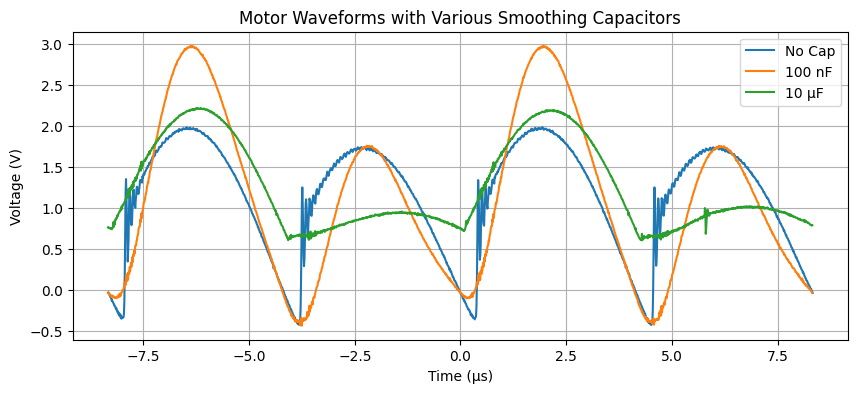

  Unnamed: 0          Name        Value
0         C1  Power Supply     10.850 V
1         C2    TX Current     17.051 A
2         C3  TX Amplitude     308.10 V
3         C3     Frequency   120.05 kHz
4         C4  RX Amplitude     1.1852 V
5         C4     Frequency   240.11 kHz
6         C4    RX Average     1.1541 V
  Unnamed: 0          Name        Value
0         C1  Power Supply     11.310 V
1         C2    TX Current     16.249 A
2         C3  TX Amplitude     318.79 V
3         C3     Frequency   120.05 kHz
4         C4  RX Amplitude    0.91390 V
5         C4    RX Average     1.1264 V
6         C4     Frequency   240.13 kHz
  Unnamed: 0          Name        Value
0         C1  Power Supply     11.248 V
1         C2    TX Current     15.380 A
2         C3  TX Amplitude     317.22 V
3         C3     Frequency   120.05 kHz
4         C4  RX Amplitude    0.61824 V
5         C4    RX Average     1.2838 V
6         C4     Frequency   120.02 kHz


In [50]:
motor = pd.read_csv('11-19_RX_motor/motor.csv', comment='#')
smooth1 = pd.read_csv('11-19_RX_motor/smooth1.csv', comment='#')
smooth2 = pd.read_csv('11-19_RX_motor/smooth2.csv', comment='#')

motor_meas = pd.read_csv('11-19_RX_motor/motor_meas.csv', comment='#')
smooth1_meas = pd.read_csv('11-19_RX_motor/smooth1_meas.csv', comment='#')
smooth2_meas = pd.read_csv('11-19_RX_motor/smooth2_meas.csv', comment='#')

period = 1/freq
start = np.argmin(np.abs(time + period))
stop = np.argmin(np.abs(time - period))

plt.figure(figsize=(10,4))
plt.plot(motor['Time (s)'][start:stop]*1e6, motor['Channel 4 (V)'][start:stop]*10, label='No Cap')
plt.plot(smooth1['Time (s)'][start:stop]*1e6, smooth1['Channel 4 (V)'][start:stop]*10, label='100 nF')
plt.plot(smooth2['Time (s)'][start:stop]*1e6, smooth2['Channel 4 (V)'][start:stop]*10, label='10 \u03BCF')
plt.xlabel('Time (\u03BCs)')
plt.ylabel('Voltage (V)')
plt.title('Motor Waveforms with Various Smoothing Capacitors')
plt.grid()
plt.legend()
plt.show()

print(motor_meas)
print(smooth1_meas)
print(smooth2_meas)

Not a robust test because position of RX probably changed, but do see slight improvements (in average) with the 10 µF vs. the 100 nF

## 11-25-25 Probe and RX with Resistor and Rectifier Measurements

Measurements and scope traces of
- the probe in the well by itself, not connected to anything
- the rectified voltage across the 1 Ohm resistor

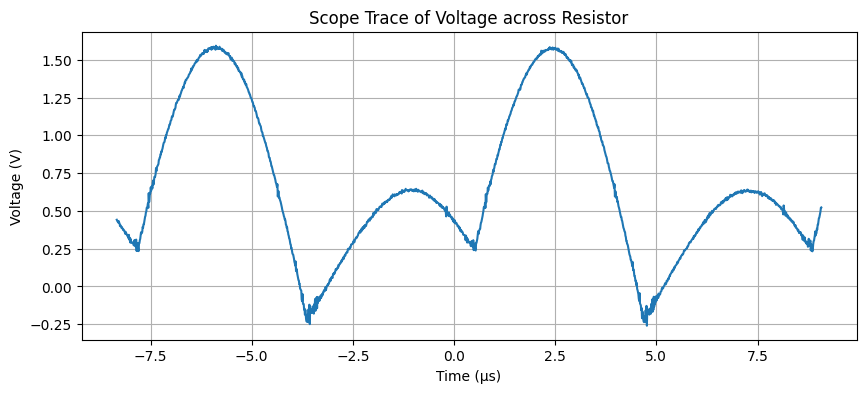

Measurement Details:
Power Supply Voltage:  11.960 V
TX Current:            17.519 A
TX Amplitude:          321.06 V
RX Average:            0.69658 V
RX/TX Frequency:       120.05 kHz


In [58]:
res = pd.read_csv('11-25_RX_res/res_rect_trace.csv', comment='#')
time = res['Time (s)'].to_numpy()
voltage = res['Channel 4 (V)'].to_numpy()*10

freq = 120*1e3
period = 1/freq
start = np.argmin(np.abs(time + 1*period))
stop = np.argmin(np.abs(time - 1*period))

plt.figure(figsize=(10,4))
plt.plot(time[start:stop+75]*1e6, voltage[start:stop+75])
plt.xlabel('Time (\u03BCs)')
plt.ylabel('Voltage (V)')
plt.title('Voltage of ')
plt.title('Scope Trace of Voltage across Resistor')
plt.grid()
plt.show()

res_meas = pd.read_csv('11-25_RX_res/res_rect_meas.csv', comment='#')
# print(res_meas)
print('Measurement Details:')
print(f'Power Supply Voltage: {res_meas['Value'][0]}')
print(f'TX Current:           {res_meas['Value'][1]}')
print(f'TX Amplitude:         {res_meas['Value'][2]}')
print(f'RX Average:           {res_meas['Value'][5]}')
print(f'RX/TX Frequency:      {res_meas['Value'][3]}')

**Conclusion: scope trace is still not as expected, so not a result of the motor**

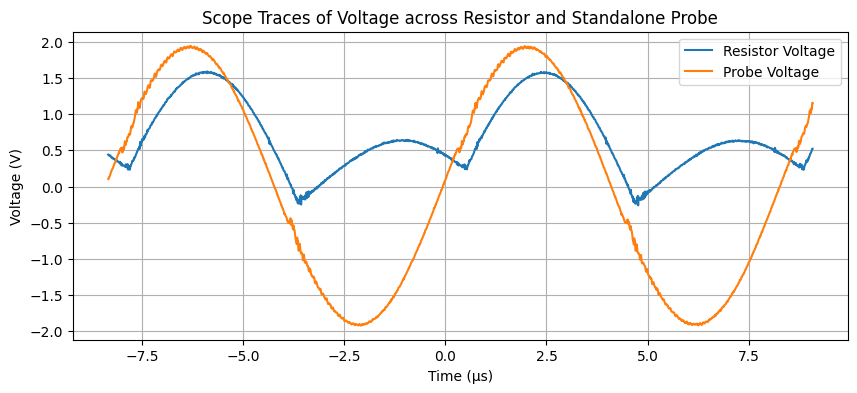

  Unnamed: 0          Name        Value
0         C1  Power Supply     12.274 V
1         C2    TX Current     19.057 A
2         C3  TX Amplitude     333.86 V
3         C3     Frequency   120.05 kHz
4         C4  RX Amplitude     1.9158 V
5         C4    RX Average    14.617 mV
6         C4     Frequency   120.05 kHz


In [26]:
probe = pd.read_csv('11-25_RX_res/probe_trace.csv', comment='#')
ptime = probe['Time (s)'].to_numpy()
pvoltage = probe['Channel 4 (V)'].to_numpy()*10

freq = 120*1e3
period = 1/freq
start = np.argmin(np.abs(time + 1*period))
stop = np.argmin(np.abs(time - 1*period))

plt.figure(figsize=(10,4))
plt.plot(time[start:stop+75]*1e6, voltage[start:stop+75], label='Resistor Voltage')
plt.plot(ptime[start:stop+75]*1e6, pvoltage[start:stop+75], label='Probe Voltage')
plt.xlabel('Time (\u03BCs)')
plt.ylabel('Voltage (V)')
plt.title('Voltage of ')
plt.title('Scope Traces of Voltage across Resistor and Standalone Probe')
plt.grid()
plt.legend()
plt.show()

probe_meas = pd.read_csv('11-25_RX_res/probe_meas.csv', comment='#')
print(probe_meas)

Note: not a great comparison because power supply is a bit different + probe was moved in position

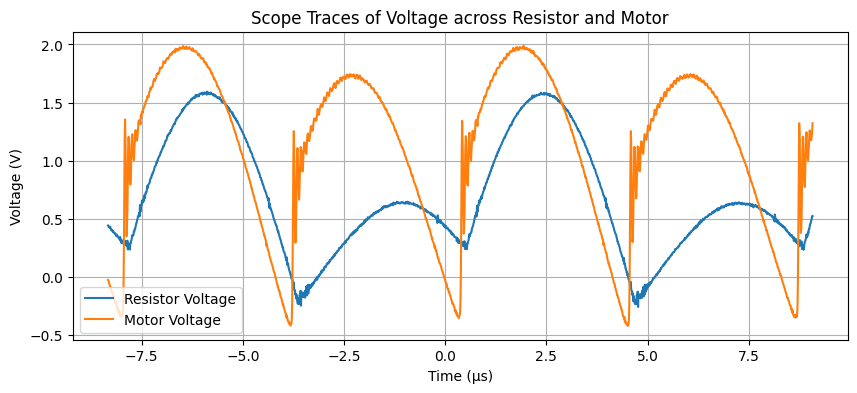

In [27]:
motor = pd.read_csv('11-19_RX_motor/motor.csv', comment='#')
mtime = motor['Time (s)'].to_numpy()
mvoltage = motor['Channel 4 (V)'].to_numpy()*10

freq = 120*1e3
period = 1/freq
start = np.argmin(np.abs(time + 1*period))
stop = np.argmin(np.abs(time - 1*period))

plt.figure(figsize=(10,4))
plt.plot(time[start:stop+75]*1e6, voltage[start:stop+75], label='Resistor Voltage')
plt.plot(mtime[start:stop+75]*1e6, mvoltage[start:stop+75], label='Motor Voltage')
plt.xlabel('Time (\u03BCs)')
plt.ylabel('Voltage (V)')
plt.title('Voltage of ')
plt.title('Scope Traces of Voltage across Resistor and Motor')
plt.grid()
plt.legend()
plt.show()

Observation: differences in peak is much different with resistor compared to motor

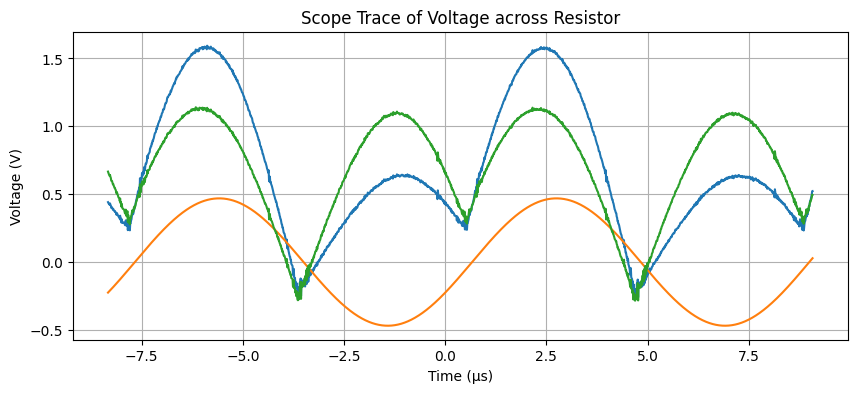

In [45]:
freq = 120*1e3
period = 1/freq
start = np.argmin(np.abs(time + period/2))
stop = np.argmin(np.abs(time - period/2))

cropped_t = time[start:stop]
cropped_V = voltage[start:stop]
peak1 = max(cropped_V[:len(cropped_t)//2])
peak2 = max(cropped_V[len(cropped_t)//2:])

A = (peak1 - peak2)/2
# art_sin = A*np.sin(-2*np.pi*freq*cropped_t+0.5)

start = np.argmin(np.abs(time + 1*period))
stop = np.argmin(np.abs(time - 1*period))
art_sin = A*np.sin(-2*np.pi*freq*time[start:stop+75]+0.5)

plt.figure(figsize=(10,4))
plt.plot(time[start:stop+75]*1e6, voltage[start:stop+75])
plt.plot(time[start:stop+75]*1e6, art_sin)
plt.plot(time[start:stop+75]*1e6, voltage[start:stop+75]-art_sin)
plt.xlabel('Time (\u03BCs)')
plt.ylabel('Voltage (V)')
plt.title('Voltage of ')
plt.title('Scope Trace of Voltage across Resistor')
plt.grid()
plt.show()

Subtracting sine wave still doesn't really help again

## 11-27-25 Probe Measurements Outside Well
Measurements and scope traces of 
- Wired measurement to probe outside well at two different voltages
- Current probe with system running and a DC test

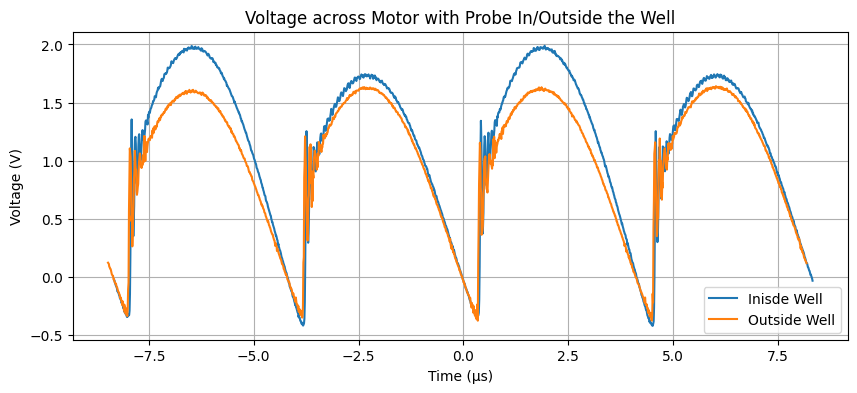

Inside Measurement Details:
Power Supply Voltage:  10.850 V
TX Current:            17.051 A
TX Amplitude:          308.10 V
TX Frequency:          120.05 kHz
RX Average:            1.1541 V
RX Frequency:          240.11 kHz

Outside Measurement Details:
Power Supply Voltage:  10.326 V
TX Current:            13.507 A
TX Amplitude:          271.29 V
TX Frequency:          119.93 kHz
RX Average:            1.0346 V
RX Frequency:          240.03 kHz


In [25]:
inside = pd.read_csv('11-19_RX_motor/motor.csv', comment='#')
outside = pd.read_csv('11-27_tests/RX_motor/trace1.csv', comment='#')

in_time = inside['Time (s)'].to_numpy()
in_volt = inside['Channel 4 (V)'].to_numpy()*10

out_time = outside['Time (s)'].to_numpy()
out_volt = outside['Channel 4 (V)'].to_numpy()*10

freq = 120*1e3
period = 1/freq
start = np.argmin(np.abs(in_time + 1*period))
stop = np.argmin(np.abs(in_time - 1*period))

plt.figure(figsize=(10,4))
plt.plot(in_time[start:stop]*1e6, in_volt[start:stop], label='Inisde Well')
plt.plot(out_time[start:stop]*1e6, out_volt[start:stop], label='Outside Well')
plt.xlabel('Time (\u03BCs)')
plt.ylabel('Voltage (V)')
plt.title('Voltage across Motor with Probe In/Outside the Well')
plt.grid()
plt.legend()
plt.show()

print('Inside Measurement Details:')
print_meas_deets('11-19_RX_motor/motor_meas.csv')

print('')

print('Outside Measurement Details:')
print_meas_deets('11-27_tests/RX_motor/trace1_meas.csv')

Voltage still goes negative but peaks level out when scoping outside the well, so maybe we can conclude outside well scoping is sufficient and look at trends in RX RMS voltage. 

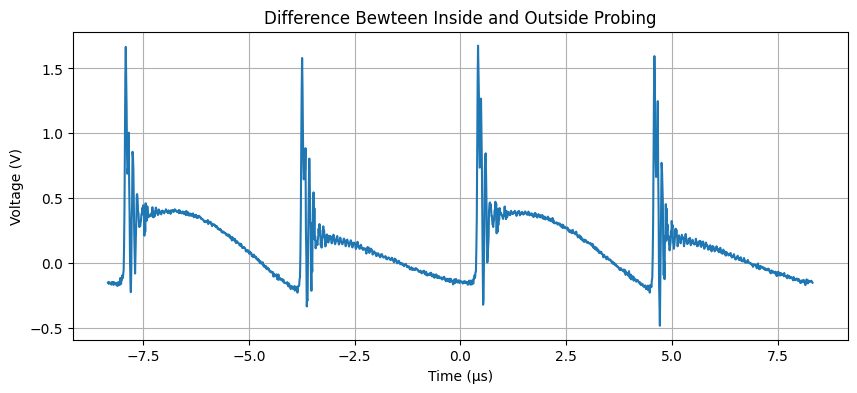

In [14]:
plt.figure(figsize=(10,4))
plt.plot(in_time[start:stop]*1e6, in_volt[start:stop] - out_volt[start:stop])
plt.xlabel('Time (\u03BCs)')
plt.ylabel('Voltage (V)')
plt.title('Difference Bewteen Inside and Outside Probing')
plt.grid()
plt.show()

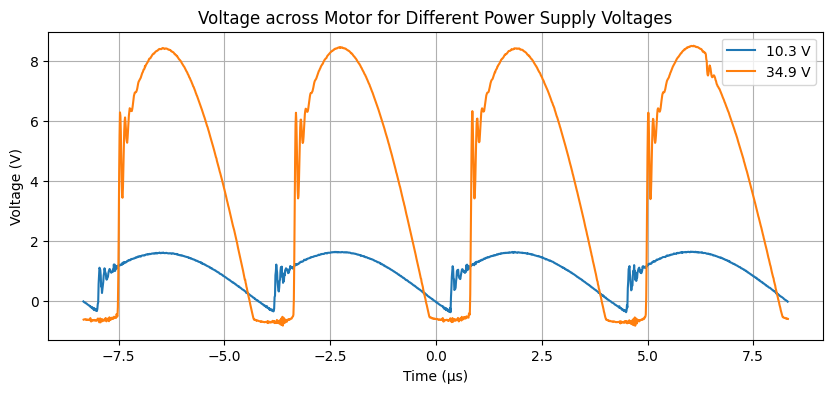

Measurement Details for Lower Power Supply Voltage:
Power Supply Voltage:  10.326 V
TX Current:            13.507 A
TX Amplitude:          271.29 V
TX Frequency:          119.93 kHz
RX Average:            1.0346 V
RX Frequency:          240.03 kHz

Measurement Details for Maximum Power Supply Voltage
Power Supply Voltage:  34.898 V
TX Current:            50.619 A
TX Amplitude:          1.0292 kV
TX Frequency:          120.07 kHz
RX Average:            4.2784 V
RX Frequency:          240.05 kHz


In [26]:
ps_max = pd.read_csv('11-27_tests/RX_motor/trace2.csv', comment='#')
max_time = ps_max['Time (s)'].to_numpy()
max_volt = ps_max['Channel 4 (V)'].to_numpy()*10

freq = 120*1e3
period = 1/freq
start = np.argmin(np.abs(max_time + 1*period))
stop = np.argmin(np.abs(max_time - 1*period))

plt.figure(figsize=(10,4))
plt.plot(out_time[start:stop]*1e6, out_volt[start:stop], label='10.3 V')
plt.plot(max_time[start:stop]*1e6, max_volt[start:stop], label='34.9 V')
plt.xlabel('Time (\u03BCs)')
plt.ylabel('Voltage (V)')
plt.title('Voltage across Motor for Different Power Supply Voltages')
plt.grid()
plt.legend()
plt.show()

print('Measurement Details for Lower Power Supply Voltage:')
print_meas_deets('11-27_tests/RX_motor/trace1_meas.csv')

print('')

print('Measurement Details for Maximum Power Supply Voltage')
print_meas_deets('11-27_tests/RX_motor/trace2_meas.csv')

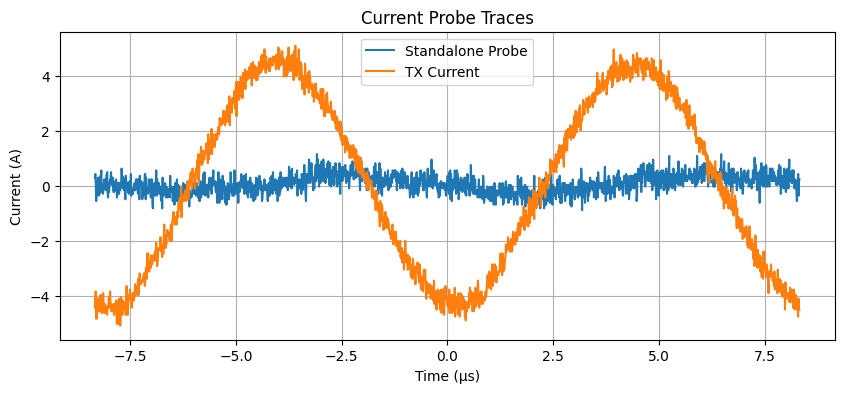

In [64]:
probe = pd.read_csv('11-27_tests/current_probe/probe.csv', comment='#')
tx_coil = pd.read_csv('11-27_tests/current_probe/TX_current.csv', comment='#')

probe_time = probe['Time (s)'].to_numpy()
probe_curr = probe['Channel 4 (V)'].to_numpy()/0.05

tx_time = tx_coil['Time (s)'].to_numpy()
tx_curr = tx_coil['Channel 4 (V)'].to_numpy()/0.05

freq = 120*1e3
period = 1/freq
start = np.argmin(np.abs(probe_time + 1*period))
stop = np.argmin(np.abs(probe_time - 1*period))

plt.figure(figsize=(10,4))
plt.plot(probe_time[start:stop]*1e6, probe_curr[start:stop], label='Standalone Probe')
plt.plot(tx_time[start:stop]*1e6, tx_curr[start:stop], label='TX Current')
# plt.plot(tx_time[start:stop]*1e6, tx_curr[start:stop] - probe_curr[start:stop], ':', label='Difference')
plt.xlabel('Time (\u03BCs)')
plt.ylabel('Current (A)')
plt.title('Current Probe Traces')
plt.grid()
plt.legend()
plt.show()

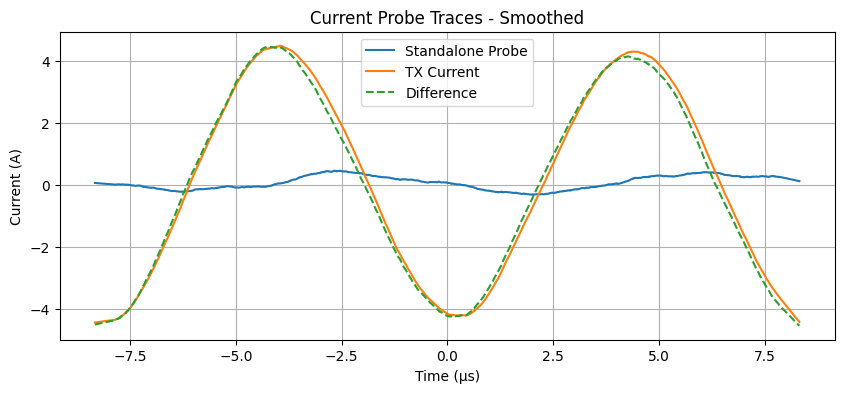

In [70]:
from scipy.signal import savgol_filter

smoothed_probe = savgol_filter(probe_curr[start:stop], 91, 1)
smoothed_tx = savgol_filter(tx_curr[start:stop], 91, 1)

plt.figure(figsize=(10,4))
plt.plot(probe_time[start:stop]*1e6, smoothed_probe, label='Standalone Probe')
plt.plot(tx_time[start:stop]*1e6, smoothed_tx, label='TX Current')
plt.plot(tx_time[start:stop]*1e6, smoothed_tx-smoothed_probe, '--', label='Difference')
plt.xlabel('Time (\u03BCs)')
plt.ylabel('Current (A)')
plt.title('Current Probe Traces - Smoothed')
plt.grid()
plt.legend()
plt.show()

**Conclusion: coupling into the probe from the magentic field is not very significant**

In [89]:
df_probe = pd.read_csv('11-27_tests/current_probe/probe_meas.csv', comment='#')
probe_val_alone = df_probe['Value'][7]

df_tx = pd.read_csv('11-27_tests/current_probe/TX_current_meas.csv', comment='#')
res_val = df_tx['Value'][1]
probe_val = df_tx['Value'][7]

print('Current Measurements (Amplitude):')
print(f'Standalone Probe:          {probe_val_alone}')
print(f'Resistor Measurement:      {res_val}')
print(f'Current Probe Measurement: {probe_val}')
print('')
print(f'Power Supply Voltage:      {df_tx['Value'][0]}')

Current Measurements (Amplitude):
Standalone Probe:           131.31 mA
Resistor Measurement:       12.839 A
Current Probe Measurement:  4.2019 A

Power Supply Voltage:       10.032 V


**Standalone probe measurement is insignificant, but probe and resistor measurements vary significantly**

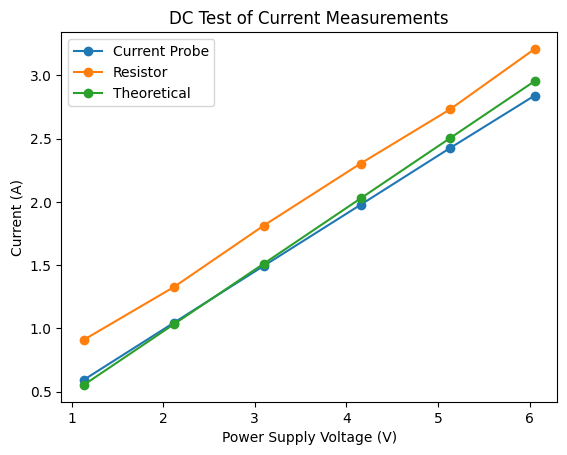

Difference between resistor measurement and theoretical current
[0.35685 0.29389 0.30126 0.27575 0.22765 0.25412]

Difference between resistor measurement and current probe
[0.31642 0.28199 0.31846 0.32585 0.30595 0.36832]


In [103]:
df_dc = pd.read_csv('11-27_tests/current_probe/dc_merge.csv')

supply = df_dc['Power Supply (V)'].to_numpy()
probe = df_dc['Current Probe (A)'].to_numpy()
res = df_dc['Resistor Meas. (A)'].to_numpy()
theo = df_dc['Theoretical (A)'].to_numpy()

plt.figure()
plt.plot(supply, probe, 'o-', label='Current Probe')
plt.plot(supply, np.abs(res), 'o-', label='Resistor')
plt.plot(supply, theo, 'o-', label='Theoretical')
plt.xlabel('Power Supply Voltage (V)')
plt.ylabel('Current (A)')
plt.title('DC Test of Current Measurements')
plt.legend()
plt.show()

print('Difference between resistor measurement and theoretical current')
print(np.abs(res) - theo)

print('')

print('Difference between resistor measurement and current probe')
print(np.abs(res) - probe)

**Conclusion: Probe is more accurate than measuring across the resistor?**

## 12-02-25 Current Measurements
Measurements of
- Current via probe and resistor across power supply voltage range
- measurements with and without the shunt resistor

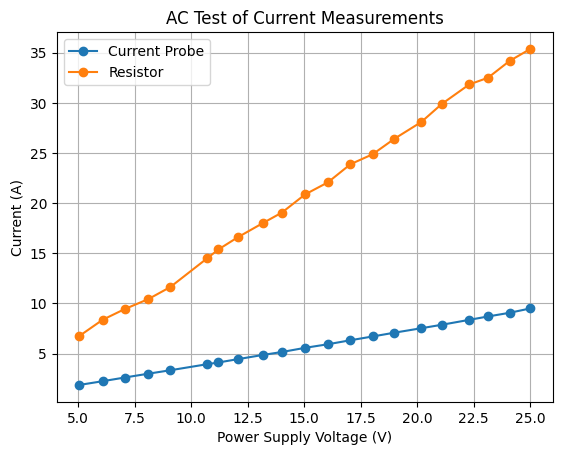

In [10]:
curr = pd.read_csv('12-02_current/probe_v_res/merged.csv')
supply = curr['Power Supply (V)'].to_numpy()
res = curr['TX Current (A)'].to_numpy()
probe = curr['Current Probe Amplitude (A)'].to_numpy()

plt.figure()
plt.plot(supply, probe, 'o-', label='Current Probe')
plt.plot(supply, res, 'o-', label='Resistor')
plt.xlabel('Power Supply Voltage (V)')
plt.ylabel('Current (A)')
plt.title('AC Test of Current Measurements')
plt.legend()
plt.grid()
plt.show()

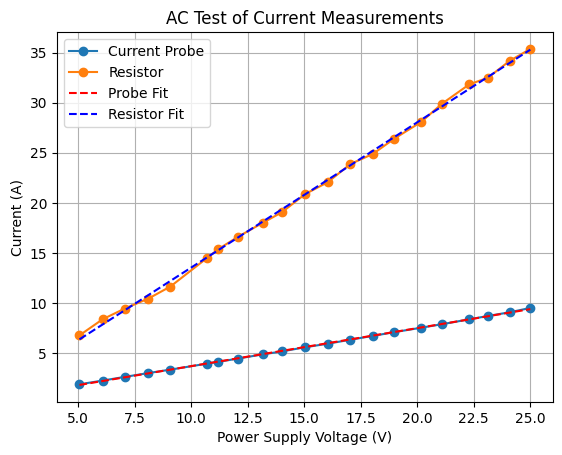

Theoretical Slope: 2.710e-03
Resistor Slope: 1.450
Current Probe Slope: 0.379


In [53]:
R = 50e-3
L = 82e-6
C = 22e-9
w = 120e3

theo_slope = (R**2 + (w*L - 1/(w*C))**2)**(-1/2)
res_slope, res_b = np.polyfit(supply, res, 1)
probe_slope, probe_b = np.polyfit(supply, probe, 1)

plt.figure()
plt.plot(supply, probe, 'o-', label='Current Probe')
plt.plot(supply, res, 'o-', label='Resistor')
plt.plot(supply, probe_slope*supply + probe_b, 'r--', label='Probe Fit')
plt.plot(supply, res_slope*supply + res_b, 'b--', label='Resistor Fit')
plt.xlabel('Power Supply Voltage (V)')
plt.ylabel('Current (A)')
plt.title('AC Test of Current Measurements')
plt.legend()
plt.grid()
plt.show()

print(f'Theoretical Slope: {theo_slope:.3e}')
print(f'Resistor Slope: {res_slope:.3f}')
print(f'Current Probe Slope: {probe_slope:.3f}')

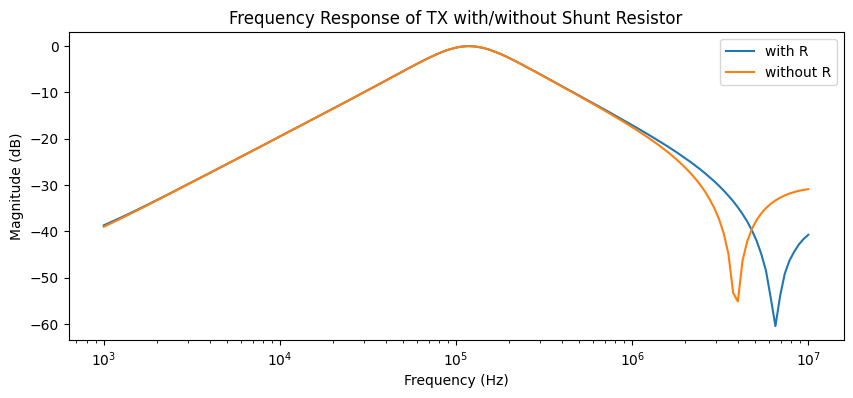

In [39]:
freqR, magR = merge_data('12-02_current/withR/freq.csv', '12-02_current/withR/freq_zoomed.csv')
freqNoR, magNoR = merge_data('12-02_current/withoutR/freq.csv', '12-02_current/withoutR/freq_zoomed.csv')

plt.figure(figsize=(10,4))
plt.semilogx(freqR, magR, label='with R')
plt.semilogx(freqNoR, magNoR, label='without R')
plt.title('Frequency Response of TX with/without Shunt Resistor')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.show()

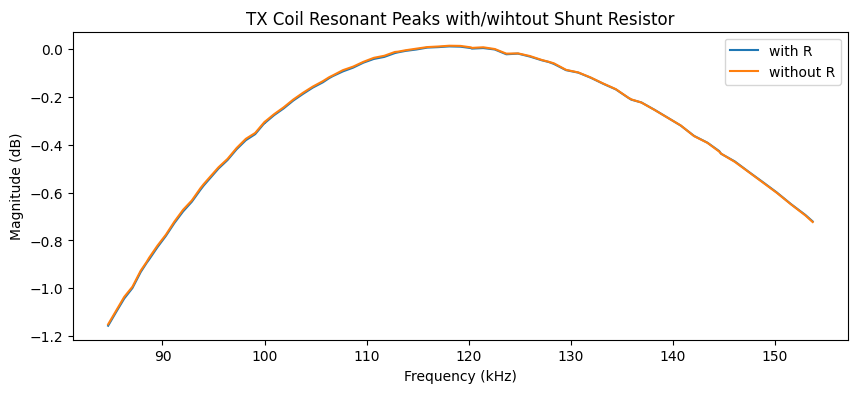

In [41]:
plt.figure(figsize=(10,4))
plt.plot(freqR[130:205]*1e-3, magR[130:205], label='with R')
plt.plot(freqNoR[130:205]*1e-3, magNoR[130:205], label='without R')

plt.title('TX Coil Resonant Peaks with/wihtout Shunt Resistor')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.show()

In [52]:
resR = get_res_freq(freqR, magR)
resNoR = get_res_freq(freqNoR, magNoR)

L_TX = calc_ind(resNoR, C=22e-9)

QR = get_Q_factor(freqR, magR)
QNoR = get_Q_factor(freqNoR, magNoR)

print('Frequency Measurements with Resistor:')
print(f'Resonant Frequency: {resR*1e-3:.3f} kHz')
print(f'Q Factor: {QR:.3f}')

print('')

print('Frequency Measurements without Resistor:')
print(f'Resonant Frequency: {resNoR*1e-3:.3f} kHz')
print(f'Q Factor: {QNoR:.3f}')

print('')
print(f'TX Idunctance, L_TX = {L_TX*1e6:.3f} µH')

Frequency Measurements with Resistor:
Resonant Frequency: 118.099 kHz
Q Factor: 0.756

Frequency Measurements without Resistor:
Resonant Frequency: 118.099 kHz
Q Factor: 0.756

TX Idunctance, L_TX = 82.551 µH


In [80]:
dfR = pd.read_csv('12-02_current/withR/meas.csv', comment='#')
dfNoR = pd.read_csv('12-02_current/withoutR/meas.csv', comment='#')

print('                            w/ resistor       w/out resistor')
print(f'Power Supply            :   {dfR['Value'][0]}           {dfNoR['Value'][0]}')
print(f'L_TX Voltage Amplitude  :   {dfR['Value'][1]}           {dfNoR['Value'][2]}')
print(f'Current Probe Amplitude :   {dfR['Value'][4]}           {dfNoR['Value'][1]}')
print(f'RX Average              :   {dfR['Value'][5]}           {dfNoR['Value'][5]}')
print(f'RX AC RMS               :   {dfR['Value'][6]}          {dfNoR['Value'][6]}')

                            w/ resistor       w/out resistor
Power Supply            :    10.694 V            10.629 V
L_TX Voltage Amplitude  :    270.46 V            277.13 V
Current Probe Amplitude :    4.8118 A            4.8533 A
RX Average              :    1.0468 V            1.0655 V
RX AC RMS               :    0.59858 Ṽ           0.64352 Ṽ


**Conclusion: removing resistor has very little effect, is more or less the same but with slightly better power transfer**

## 12-04-25 System Measurements
Measurements of the system as a function of 
- power supply voltage
- driving frequency

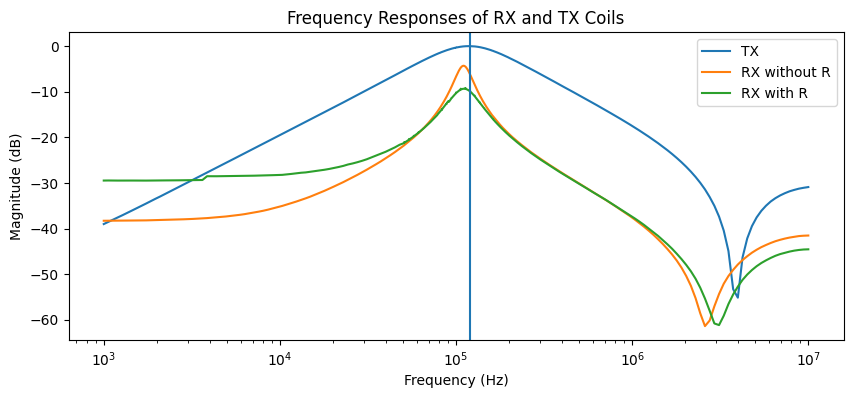

In [25]:
freqTX, magTX = merge_data('12-02_current/withoutR/freq.csv', '12-02_current/withoutR/freq_zoomed.csv')
freqRX, magRX = merge_data('11-17_RX_coils/coil5_C0G_freq.csv', '11-17_RX_coils/coil5_C0G_freq_zoomed.csv')
freqRXR1, magRXR1 = merge_data('11-17_RX_coils/coil5_C0G_R1_freq.csv', '11-17_RX_coils/coil5_C0G_R1_freq_zoomed.csv')

plt.figure(figsize=(10,4))
plt.semilogx(freqTX, magTX, label='TX')
plt.semilogx(freqRX, magRX, label='RX without R')
plt.semilogx(freqRXR1, magRXR1, label='RX with R')
plt.axvline(x=120*1e3)
plt.title('Frequency Responses of RX and TX Coils')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.show()

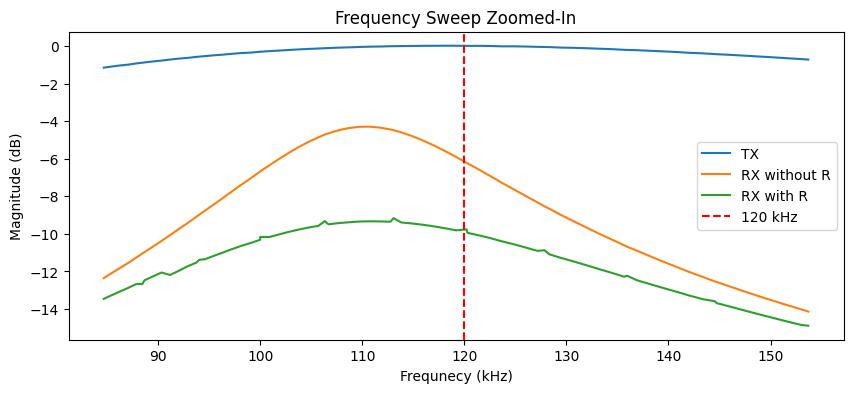

In [37]:
plt.figure(figsize=(10,4))
plt.plot(freqTX[130:205]*1e-3, magTX[130:205], label='TX')
plt.plot(freqRX[130:205]*1e-3, magRX[130:205], label='RX without R')
plt.plot(freqRXR1[130:205]*1e-3, magRXR1[130:205], label='RX with R')
plt.axvline(x=120, color='r', linestyle='--', label='120 kHz')
plt.xlabel('Frequnecy (kHz)')
plt.ylabel('Magnitude (dB)')
plt.title('Frequency Sweep Zoomed-In')
plt.legend()
plt.show()

Current opereating frequency is close to the resonant peak but there is room for improvement

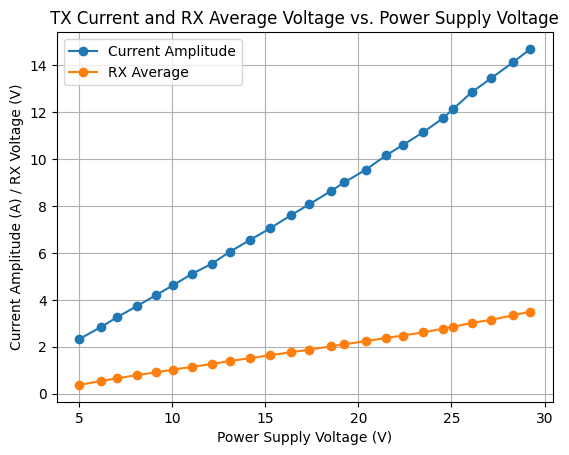

In [46]:
df = pd.read_csv('12-04_RX_meas/supply/merged.csv')
supply = df['Power Supply Avg (V)'].to_numpy()
current = df['TX Current (A)'].to_numpy()
rx_avg = df['RX Average (V)'].to_numpy()

plt.figure()
plt.plot(supply, current, 'o-', label='Current Amplitude')
plt.plot(supply, rx_avg, 'o-', label='RX Average')
plt.xlabel('Power Supply Voltage (V)')
plt.ylabel('Current Amplitude (A) / RX Voltage (V)')
plt.title('TX Current and RX Average Voltage vs. Power Supply Voltage')
plt.legend()
plt.grid()
plt.show()

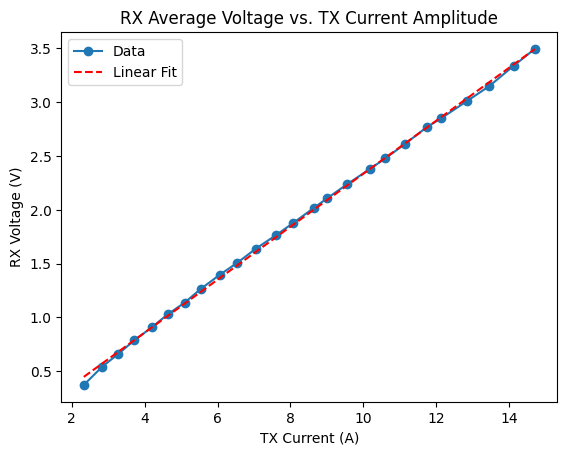

k Calculated: 0.011791596019880871
k Approx: 0.04


In [22]:
m, b = np.polyfit(current, rx_avg, 1)

plt.figure()
plt.plot(current, rx_avg, 'o-', label='Data')
plt.plot(current, m*current+b, 'r--', label='Linear Fit')
plt.xlabel('TX Current (A)')
plt.ylabel('RX Voltage (V)')
plt.title('RX Average Voltage vs. TX Current Amplitude')
plt.legend()
plt.show()

LTX = 82.551*1e-6
LRX = 9.30*1e-6
w = 2*np.pi*120e3
k_theo = m/(w*np.sqrt(LTX*LRX))

DTX = 30e-2
DRX = 6e-2
k_rough = DRX**2 / DTX**2

print(f'k Calculated: {k_theo}')
print(f'k Approx: {k_rough}')

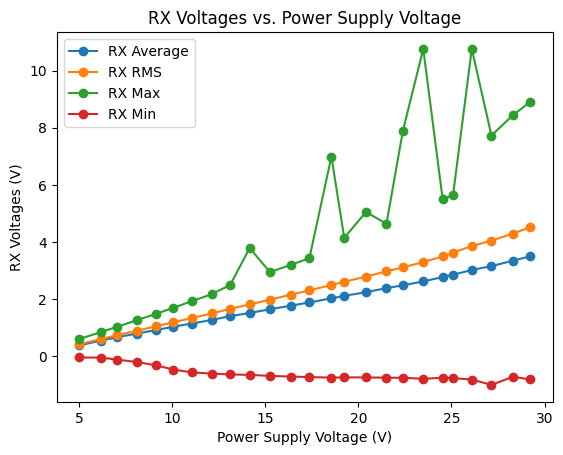

In [24]:
df = pd.read_csv('12-04_RX_meas/supply/merged.csv')
rx_avg = df['RX Average (V)'].to_numpy()
rx_rms = df['RX RMS (V)'].to_numpy()
rx_max = df['RX Max (V)'].to_numpy()
rx_min = df['RX Min (V)'].to_numpy()

plt.figure()
plt.plot(supply, rx_avg, 'o-', label='RX Average')
plt.plot(supply, rx_rms, 'o-', label='RX RMS')
plt.plot(supply, rx_max, 'o-', label='RX Max')
plt.plot(supply, rx_min, 'o-', label='RX Min')
plt.xlabel('Power Supply Voltage (V)')
plt.ylabel('RX Voltages (V)')
plt.title('RX Voltages vs. Power Supply Voltage')
plt.legend()
plt.show()

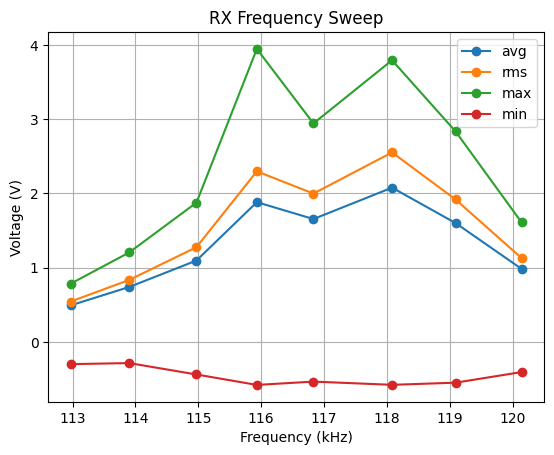

In [57]:
df = pd.read_csv('12-04_RX_meas/freq1/merged.csv')
freq = df['TX Frequency (Hz)'].to_numpy()
# current = df['TX Current (A)'].to_numpy()
rx_avg = df['RX Average (V)'].to_numpy()
rx_rms = df['RX RMS (V)'].to_numpy()
rx_max = df['RX Max (V)'].to_numpy()
rx_min = df['RX Min (V)'].to_numpy()

plt.figure()
plt.plot(freq[:-1]*1e-3, rx_avg[:-1], 'o-', label='avg')
plt.plot(freq[:-1]*1e-3, rx_rms[:-1], 'o-', label='rms')
plt.plot(freq[:-1]*1e-3, rx_max[:-1], 'o-', label='max')
plt.plot(freq[:-1]*1e-3, rx_min[:-1], 'o-', label='min')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Voltage (V)')
plt.title('RX Frequency Sweep')
plt.legend()
plt.grid()
plt.show()

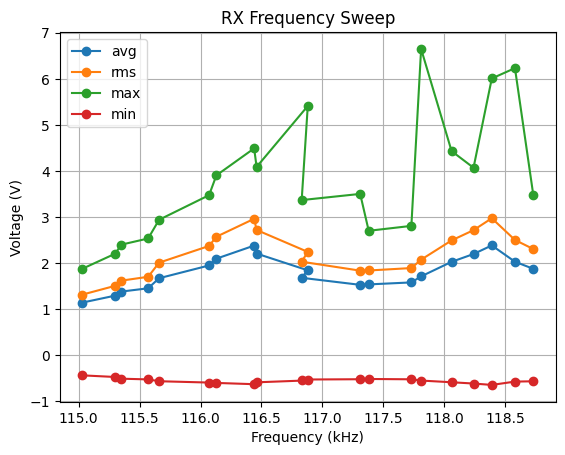

In [48]:
df = pd.read_csv('12-04_RX_meas/freq2/merged.csv')
freq = df['TX Frequency (Hz)'].to_numpy()
rx_avg = df['RX Average (V)'].to_numpy()
rx_rms = df['RX RMS (V)'].to_numpy()
rx_max = df['RX Max (V)'].to_numpy()
rx_min = df['RX Min (V)'].to_numpy()

plt.figure()
plt.plot(freq[:-1]*1e-3, rx_avg[:-1], 'o-', label='avg')
plt.plot(freq[:-1]*1e-3, rx_rms[:-1], 'o-', label='rms')
plt.plot(freq[:-1]*1e-3, rx_max[:-1], 'o-', label='max')
plt.plot(freq[:-1]*1e-3, rx_min[:-1], 'o-', label='min')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Voltage (V)')
plt.title('RX Frequency Sweep')
plt.legend()
plt.grid()
plt.show()

Above was being current limited by the power supply

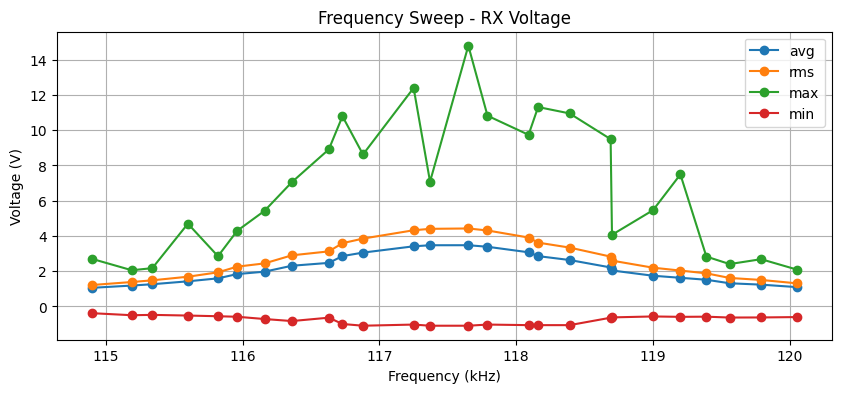

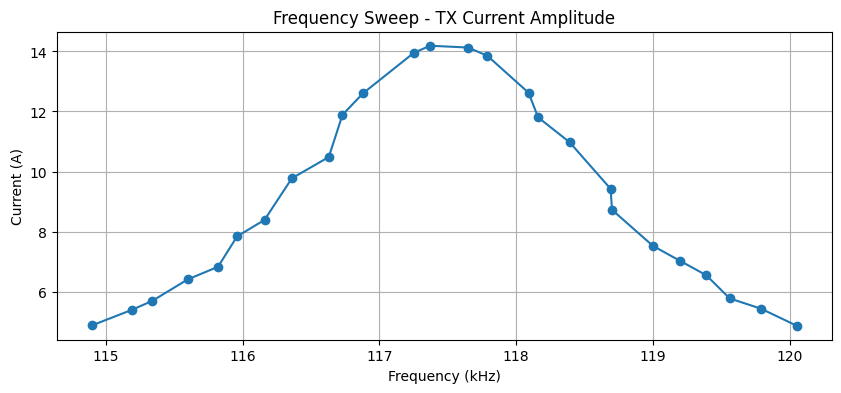

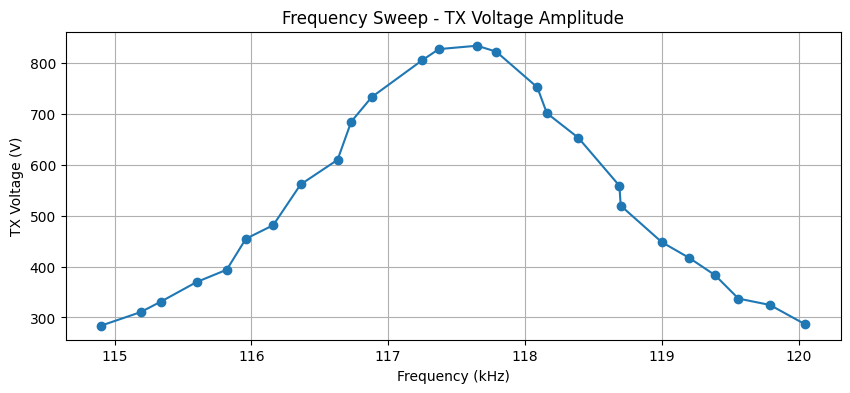

In [58]:
df = pd.read_csv('12-04_RX_meas/freq6/merged.csv')
freq = df['TX Frequency (Hz)'].to_numpy()
rx_avg = df['RX Average (V)'].to_numpy()
rx_rms = df['RX RMS (V)'].to_numpy()
rx_max = df['RX Max (V)'].to_numpy()
rx_min = df['RX Min (V)'].to_numpy()

plt.figure(figsize=(10,4))
plt.plot(freq*1e-3, rx_avg, 'o-', label='avg')
plt.plot(freq*1e-3, rx_rms, 'o-', label='rms')
plt.plot(freq*1e-3, rx_max, 'o-', label='max')
plt.plot(freq*1e-3, rx_min, 'o-', label='min')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Voltage (V)')
plt.title('Frequency Sweep - RX Voltage')
plt.legend()
plt.grid()
plt.show()

current = df['TX Current (A)'].to_numpy()
plt.figure(figsize=(10,4))
plt.plot(freq*1e-3, current, 'o-')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Current (A)')
plt.title('Frequency Sweep - TX Current Amplitude')
plt.grid()
plt.show()

tx_volt = df['TX Amplitude (V)'].to_numpy()
plt.figure(figsize=(10,4))
plt.plot(freq*1e-3, tx_volt, 'o-')
plt.xlabel('Frequency (kHz)')
plt.ylabel('TX Voltage (V)')
plt.title('Frequency Sweep - TX Voltage Amplitude')
plt.grid()
plt.show()

**Huge effect when running on resonance &mdash; new operating frequency of 117 kHz**